# Hicberg tutorial

This notebook aims to provide a simple tutorial on how to use the Hicberg package to analyze Hi-C data.

The package is designed to be user-friendly and easy to use, and it provides a wide range of tools for the analysis of Hi-C data. 

The tutorial will cover all steps of the analysis, from data loading to visualization of results.

## Importing libraries

In [50]:
# Import from standard libraries
import time
import glob, sys
from glob import glob
from shutil import which, rmtree
from os.path import join
from pathlib import Path
import subprocess as sp

## Mutlitprocessing puroposes
import multiprocessing
from multiprocessing import Process
from functools import partial

import numpy as np
import cooler
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Import from hicberg
import hicberg.align as hal
import hicberg.io as hio
import hicberg.utils as hut
import hicberg.plot as hpl
import hicberg.statistics as hst


## Paths and parameters setting

Parameters are set to perform standard analysis of Hi-C data.

No blacklisted regions are used in this tutorial.

In [2]:
UNRESCUED_MATRIX = "unrescued_map.cool"
RESTRICTION_MAP = "restriction_map.npy"

# Directories
output_directory = "./tmp"
analysis_name = "my_library"

# Data
# genome = "data/V_cholerae_O1.fa"
# forward_reads = "data/SRR10394900_CC340_V.cholera_HiC_using_HpaII_-_biological_replicate_1_1.fastq.gz"
# reverse_reads = "data/SRR10394900_CC340_V.cholera_HiC_using_HpaII_-_biological_replicate_1_1.fastq.gz"

genome = "data/SC288_with_micron.fa"
forward_reads = "/home/sardine/Bureau/tutorial/data/AC1.end1.fastq.gz"
reverse_reads = "/home/sardine/Bureau/tutorial/data/AC1.end2.fastq.gz"

# Experiment dependant parameters
restriction_enzyme = ["DpnII", "HinfI"]
circular = [""]
rate = 1.0
resolution = 2000
mode = "standard"
blacklist = None 

cpus = 16



## Step 0: Creating analyses directories

In [3]:
output_folder = hio.create_folder(sample_name = analysis_name, output_dir = output_directory)

2024-10-17 -- 08:45:39 :: INFO :: Creating folder my_library in ./tmp
2024-10-17 -- 08:45:39 :: INFO :: Folder my_library in tmp/my_library created.


## Step 1: Get chromosomes size and align reads

This step aims to define the size of the chromosomes (and relative binning), and align the reads to the reference genome.

Reads are going to be aligned in "very sensitive" mode for a better accuracy.

Mapping quality is set to 30 (default) and all reads are going to be kept (max_alignment = -1).


In [4]:
hut.get_chromosomes_sizes(genome = genome, output_dir = output_folder)
hut.get_bin_table(bins = resolution, output_dir = output_folder)


2024-10-17 -- 08:45:39 :: INFO :: Start getting chromosome sizes
2024-10-17 -- 08:45:39 :: INFO :: Chromosome sizes have been saved in tmp/my_library/chromosome_sizes.npy
2024-10-17 -- 08:45:39 :: INFO :: Start getting bin table


In [5]:
# Index the genome
index = "SC288_with_micron" 

hal.hic_build_index(genome = genome, output_dir = output_folder, cpus = cpus)

# Align reads
hal.hic_align(index = index, fq_for = forward_reads, fq_rev = reverse_reads, sensitivity = "very-sensitive", max_alignment = -1,
            output_dir = output_folder, cpus = cpus)
# Convert to .bam
hal.hic_view(cpus = cpus, output_dir = output_folder)

# Sort reads by name
hal.hic_sort(cpus = cpus, output_dir = output_folder)

2024-10-17 -- 08:45:39 :: INFO :: Start building index for alignment
2024-10-17 -- 08:45:45 :: INFO :: Index built at tmp/my_library/SC288_with_micron
2024-10-17 -- 08:45:45 :: INFO :: Start aligning reads
2024-10-17 -- 08:52:58 :: INFO :: 47310032 reads; of these:
  47310032 (100.00%) were unpaired; of these:
    2845860 (6.02%) aligned 0 times
    39601500 (83.71%) aligned exactly 1 time
    4862672 (10.28%) aligned >1 times
93.98% overall alignment rate

2024-10-17 -- 08:52:58 :: INFO :: 47310032 reads; of these:
  47310032 (100.00%) were unpaired; of these:
    2293189 (4.85%) aligned 0 times
    40099611 (84.76%) aligned exactly 1 time
    4917232 (10.39%) aligned >1 times
95.15% overall alignment rate

2024-10-17 -- 08:52:58 :: INFO :: Alignment saved at tmp/my_library
2024-10-17 -- 08:52:58 :: INFO :: Start converting .sam to .bam
2024-10-17 -- 08:53:45 :: INFO :: Compressed  alignment done at tmp/my_library
2024-10-17 -- 08:53:45 :: INFO :: Start sorting .bam alignment files
[b

## Step 3: Classification of read pairs

All reads read pairs previously produced are going to be classified in the following categories:

- Unmapped pairs : read pairs that are not aligned to the reference genome (at least one read is unmapped)
- Unambiguous pairs : read pairs that are aligned to the reference genome and are uniquely mapped (both reads are uniquely mapped)
- Ambiguous pairs : read pairs that are aligned to the reference genome and are not uniquely mapped (at least one read is not uniquely mapped) or too poorly mapped (mapping quality < 35)

In [6]:
hut.classify_reads( output_dir = output_folder)

2024-10-17 -- 09:14:57 :: INFO :: Files for the different groups have been saved in tmp/my_library
2024-10-17 -- 09:14:57 :: INFO :: Number of unmapped reads in forward file : 7580990
2024-10-17 -- 09:14:57 :: INFO :: Number of unmapped reads in reverse file : 8224108
2024-10-17 -- 09:14:57 :: INFO :: Number of uniquely mapped reads in forward file : 35472762
2024-10-17 -- 09:14:57 :: INFO :: Number of uniquely mapped reads in reverse file : 35472762
2024-10-17 -- 09:14:57 :: INFO :: Number of multi mapped reads in forward file : 59443286
2024-10-17 -- 09:14:57 :: INFO :: Number of multi mapped reads in reverse file : 56970596


## Step 4: Build contact matrix

Hi-C contact matrix is going to be built using the read pairs classified in the previous step.

The produced contact matrix (in .cool) is going to be normalized using the ICE method.

In [7]:
hio.build_pairs(output_dir = output_folder)
hio.build_matrix(cpus = cpus, balance = True, output_dir = output_folder)

2024-10-17 -- 09:14:57 :: INFO :: Start building pairs file for unambiguously aligned reads
2024-10-17 -- 09:16:27 :: INFO :: Pairs file successfully created in tmp/my_library
INFO:cooler.create:Writing chunk 0: /home/sardine/Bureau/tutorial/tmp/my_library/tmpt4gyxh59.multi.cool::0
INFO:cooler.create:Creating cooler at "/home/sardine/Bureau/tutorial/tmp/my_library/tmpt4gyxh59.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 1: /home/sardine/Bureau/tutorial/tmp/my_library/tmpt4gyxh59.multi.cool::1
INFO:cooler.create:Creating cooler at "/home/sardine/Bureau/tutorial/tmp/my_library/tmpt4gyxh59.multi.cool::/1"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 2: /home/sardine/Bu

### Visualizing the contact matrix

/tmp/ipykernel_3133923/3058769468.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(chromosome_I), cmap = "YlOrRd", vmin = -3.5, vmax = -1.2)


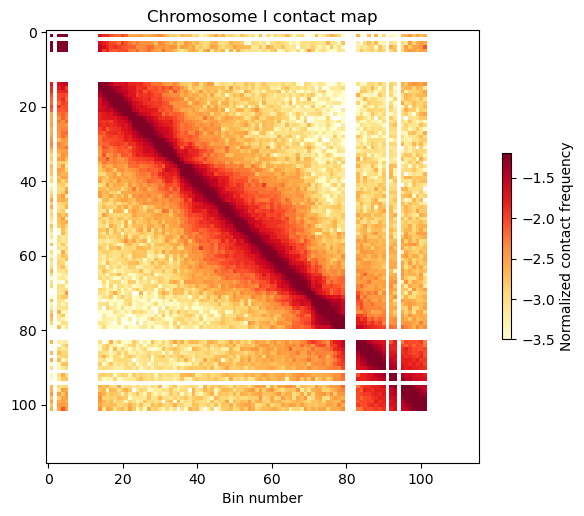

In [43]:
matrix = cooler.Cooler("./tmp/my_library/unrescued_map.cool")
chromosome_I = matrix.matrix(balance = True).fetch("chr1")

plt.figure(figsize=(6,6))
plt.imshow(np.log10(chromosome_I), cmap = "YlOrRd", vmin = -3.5, vmax = -1.2)
plt.colorbar(fraction = 0.02, label = "Normalized contact frequency")
plt.title("Chromosome I contact map")
plt.xlabel("Bin number")
plt.show()


## Step 5: Profiling Hi-C data

Statistical profiling of the Hi-C data is going to be performed.

The following metrics are going to be calculated (standard mode):
- $P(s)$ : the probability of contact between two loci separated by a genomic distance $s$
- Coverage : the read coverage of the Hi-C data per bin

In [9]:
# Get the restriction map of the genome
restriction_map = hst.get_restriction_map(genome = genome, enzyme = restriction_enzyme, output_dir = output_folder)

# Compute the distance between fragments and bin the genome
hst.get_dist_frags(genome = genome, restriction_map = restriction_map, circular = circular, rate = rate, output_dir = output_folder)
hst.log_bin_genome(genome = genome, output_dir = output_folder)

# Define the profiles to be established
p1 = Process(target = hst.get_patterns, kwargs = dict(circular = circular, output_dir = output_folder))
p2 = Process(target = hst.generate_trans_ps, kwargs = dict(output_dir = output_folder))
p3 = Process(target = hst.generate_coverages, kwargs = dict(genome = genome, bins = resolution, output_dir = output_folder))

# Start the processes
for process in [p1, p2, p3]:
            process.start()

for process in [p1, p2, p3]:
    process.join()

2024-10-17 -- 09:18:46 :: INFO :: Generating restriction map...
2024-10-17 -- 09:18:47 :: INFO :: Saved restriction map at : tmp/my_library
2024-10-17 -- 09:18:47 :: INFO :: Start generating distribution of fragments' distance...
2024-10-17 -- 09:27:13 :: INFO :: Saved restriction map at : tmp/my_library/dist.frag.npy
2024-10-17 -- 09:27:13 :: INFO :: Start log binning of genome...
2024-10-17 -- 09:27:13 :: INFO :: Log binning of genome data/SC288_with_micron.fa saved in tmp/my_library/xs.npy.
2024-10-17 -- 09:27:13 :: INFO :: Start generating patterns distribution...
2024-10-17 -- 09:27:13 :: INFO :: Start getting trans-P(s)
2024-10-17 -- 09:27:13 :: INFO :: Start generating coverages...
2024-10-17 -- 09:27:22 :: INFO :: Trans P(s) saved in tmp/my_library
2024-10-17 -- 09:30:50 :: INFO :: Coverage dictionary saved in tmp/my_library
2024-10-17 -- 09:33:10 :: INFO :: Saved weirds.npy, uncuts.npy and loops.npy in tmp/my_library


## Step 6: Infer ambiguous read pairs from statistical profile

Previously profiled Hi-C data is going to be used to infer ambiguous read pairs.

In [10]:
# Reload restriction map
restriction_map = hio.load_dictionary(Path(output_folder) / RESTRICTION_MAP)

# Split the alignement files
hut.chunk_bam(nb_chunks = 32, output_dir = output_folder)

# Get chunks as lists
forward_chunks, reverse_chunks = hut.get_chunks(output_dir = output_folder)

# Reattribute reads
with multiprocessing.Pool(processes = cpus) as pool: # cpus

    results = pool.map(partial(hst.reattribute_reads, mode = mode, restriction_map = restriction_map, output_dir = output_folder),
    zip(forward_chunks, reverse_chunks))
    pool.close()
    pool.join()

hio.merge_predictions(output_dir = output_folder, clean = True, cpus = cpus)

# Temporary files cleaning
folder_to_delete = Path(output_folder) / 'chunks'
rmtree(folder_to_delete)

2024-10-17 -- 09:33:10 :: INFO :: Start chunking BAM files
2024-10-17 -- 09:41:16 :: INFO :: Chunks saved in tmp/my_library/chunks
2024-10-17 -- 09:44:14 :: INFO :: Predictions written in tmp/my_library
2024-10-17 -- 09:44:23 :: INFO :: Predictions written in tmp/my_library
2024-10-17 -- 09:44:32 :: INFO :: Predictions written in tmp/my_library
2024-10-17 -- 09:44:36 :: INFO :: Predictions written in tmp/my_library
2024-10-17 -- 09:44:37 :: INFO :: Predictions written in tmp/my_library
2024-10-17 -- 09:44:37 :: INFO :: Predictions written in tmp/my_library
2024-10-17 -- 09:44:38 :: INFO :: Predictions written in tmp/my_library
2024-10-17 -- 09:44:38 :: INFO :: Predictions written in tmp/my_library
2024-10-17 -- 09:44:39 :: INFO :: Predictions written in tmp/my_library
2024-10-17 -- 09:44:39 :: INFO :: Predictions written in tmp/my_library
2024-10-17 -- 09:44:39 :: INFO :: Predictions written in tmp/my_library
2024-10-17 -- 09:44:41 :: INFO :: Predictions written in tmp/my_library
2024-

## Step 7: Build contact matrix with inferred read pairs

In [11]:
# Build pairs with both ambiguous  and infered reads
hio.build_pairs(mode = True, output_dir = output_folder)
# Build reconstructed matrix
hio.build_matrix(cpus = cpus, balance = True, mode = True, output_dir = output_folder)

2024-10-17 -- 09:48:06 :: INFO :: Start building pairs file for ambiguously aligned reads
2024-10-17 -- 09:49:55 :: INFO :: Pairs file successfully created in tmp/my_library
INFO:cooler.create:Writing chunk 0: /home/sardine/Bureau/tutorial/tmp/my_library/tmp0fen71zc.multi.cool::0
INFO:cooler.create:Creating cooler at "/home/sardine/Bureau/tutorial/tmp/my_library/tmp0fen71zc.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 1: /home/sardine/Bureau/tutorial/tmp/my_library/tmp0fen71zc.multi.cool::1
INFO:cooler.create:Creating cooler at "/home/sardine/Bureau/tutorial/tmp/my_library/tmp0fen71zc.multi.cool::/1"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 2: /home/sardine/Bure

## Step 8: Plot the reconstructed matrix and profiles

In [12]:
p1 = Process(target = hpl.plot_laws, kwargs = dict(output_dir = output_folder))
p2 = Process(target = hpl.plot_trans_ps, kwargs = dict(output_dir = output_folder))
p3 = Process(target = hpl.plot_coverages, kwargs = dict(bins = resolution, output_dir = output_folder))

for process in [p1, p2, p3]:

        process.start()
# Launch processes
for process in [p1, p2, p3]:

        process.join()

2024-10-17 -- 09:52:30 :: INFO :: Saved coverages at : tmp/my_library
2024-10-17 -- 09:52:35 :: INFO :: Saved plots of patterns at : tmp/my_library
2024-10-17 -- 09:52:36 :: INFO :: Saved pseudo P(s) of patterns at : tmp/my_library


In [40]:
# Load reconstructed matrix
matrix_reconstructed = cooler.Cooler("./tmp/my_library/rescued_map.cool")

chromosome_I_reconstructed = matrix_reconstructed.matrix(balance = True).fetch("chr1")

### Visualizing the contact matrix

Chromosome I exhibits a clear diagonal pattern, which is expected for Hi-C data.

Hicberg was able to reconstruct the contact matrix with the inferred read pairs, and allow better visualization of (sub)telomere contact behavior.

/tmp/ipykernel_3133923/382376023.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(chromosome_I), cmap="YlOrRd", vmin=-3.5, vmax=-1.2)
/tmp/ipykernel_3133923/382376023.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(chromosome_I_reconstructed), cmap="YlOrRd", vmin=-3.5, vmax=-1.2)


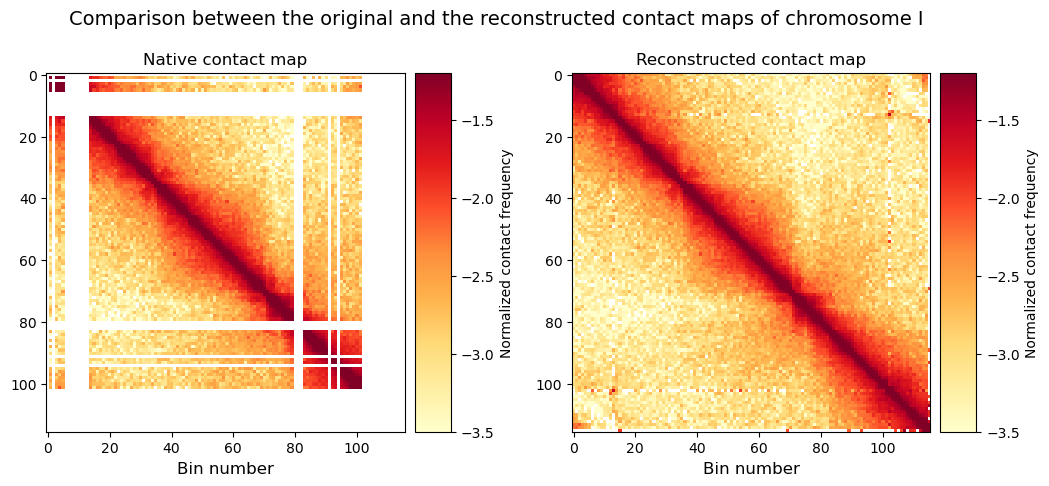

In [75]:
plt.figure(figsize=(12,6))

plt.subplots_adjust(wspace=0.3)
ax1 = plt.subplot(1, 2, 1)
plt.imshow(np.log10(chromosome_I), cmap="YlOrRd", vmin=-3.5, vmax=-1.2)
plt.title("Native contact map")
plt.xlabel("Bin number", fontsize = 12)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(np.log10(chromosome_I_reconstructed), cmap="YlOrRd", vmin=-3.5, vmax=-1.2)
plt.title("Reconstructed contact map")
plt.xlabel("Bin number", fontsize=12)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="10%", pad=0.1)  # Adjust size and pad as needed
plt.colorbar(cax=cax1, label="Normalized contact frequency")

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="10%", pad=0.1)
plt.colorbar(cax=cax2, label="Normalized contact frequency")
plt.suptitle("Comparison between the original and the reconstructed contact maps of chromosome I", position=(0.5, 0.9), fontsize = 14)

plt.show()

### Visualizing the profiling results

Here we can see the $P(s)$ and coverage profiles of the Hi-C data before and after the inference of ambiguous read pairs.

For tutorial purposes, only chromosome I will be visualized.

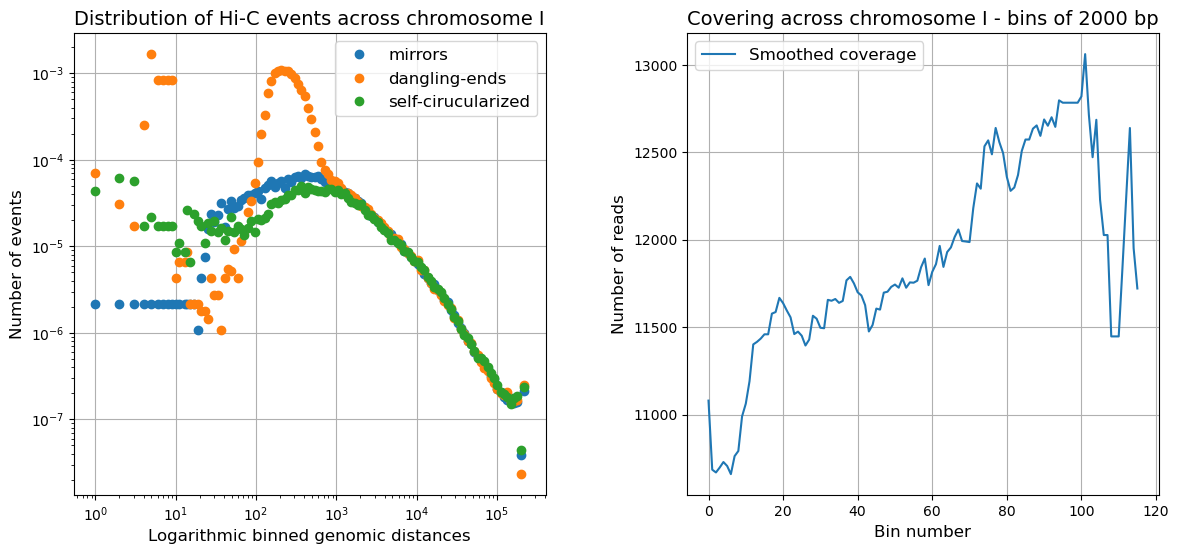

In [98]:
# reaload the statistics
xs = hio.load_dictionary("./tmp/my_library/xs.npy")
weirds = hio.load_dictionary("./tmp/my_library/weirds.npy")
uncuts = hio.load_dictionary("./tmp/my_library/uncuts.npy")
loops = hio.load_dictionary("./tmp/my_library/loops.npy")

chromosome = "chr1"    
plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.3)
ax1 = plt.subplot(121)

ax1.loglog(xs[chromosome], weirds[chromosome], "o", label="mirrors")
ax1.loglog(xs[chromosome], uncuts[chromosome], "o", label="dangling-ends")
ax1.loglog(xs[chromosome], loops[chromosome], "o", label="self-cirucularized")
ax1.set_title(f"Distribution of Hi-C events across chromosome I", fontsize = 14)
ax1.set_xlabel("Logarithmic binned genomic distances", fontsize = 12)
ax1.set_ylabel("Number of events", fontsize = 12)
ax1.grid()
ax1.legend(fontsize = 12)

ax2 = plt.subplot(122)
ax2.plot(coverage[chromosome], label="Smoothed coverage")        
ax2.set_title(f"Covering across chromosome I - bins of {resolution} bp", fontsize = 14)
ax2.set_xlabel(f"Bin number", fontsize = 12)
ax2.set_ylabel("Number of reads", fontsize = 12)
ax2.legend(fontsize = 12)
ax2.grid()
plt.show()

## Step 9: Clean temppoary files

In [15]:
hio.tidy_folder(output_dir = output_folder)